In [ ]:
!pip install transformers
!pip install evaluate
!pip install sentencepiece

In [2]:
import pandas as pd
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import T5Model, T5ForConditionalGeneration, T5TokenizerFast
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install rouge-score
from rouge_score import rouge_scorer

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=07c4a4e77fc31ce8c3f0bcc13710aee97217a057a164836705f917d0b730fb6c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import custom module

In [4]:
%cd /content/drive/MyDrive/ITMO/T5QA/src
%ls

/content/drive/MyDrive/ITMO/T5QA/src
medqadataset.py  __pycache__/  trainer.py


In [5]:
from medqadataset import MedQADataset
import trainer

In [6]:
# For debugging
import importlib
importlib.reload(trainer)

<module 'trainer' from '/content/drive/MyDrive/ITMO/T5QA/src/trainer.py'>

In [6]:
#MODEL_NAME = "cointegrated/rut5-base"    # pre-trained model (first iteration)
MODEL_NAME = "/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel_aug_ans2"
TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME, local_files_only=True)
#TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME)
# Set up the T5 model
MODEL = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
# Set up the optimizer
OPTIMIZER = Adam(MODEL.parameters(), lr=0.0001)
Q_LEN = 512    # Question Length
T_LEN = 128    # Target Length
BATCH_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
DEVICE

'cuda'

### Read Data

In [9]:
PATH = '/content/drive/MyDrive/ITMO/T5QA'

data = pd.read_csv(PATH + '/data/MedQuAD_answers_augmented_concat.csv', index_col=0)
data.index = [i for i in range(len(data))]

data

,question,context,answer
0,что такое кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляе...,кератодермия с пушистыми волосами представляет...
1,сколько людей с шерстяными волосами страдают к...,кератодермия с пушистыми волосами представляе...,кератодермия с пушистыми волосами встречается ...
2,"каковы генетические изменения, связанные с кер...",кератодермия с пушистыми волосами представляе...,"мутации в генах jup, dsp, dsc2 и kank2 вызываю..."
3,передается ли кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляе...,большинство случаев кератодермии с курчавыми в...
4,что такое синдром кноблоха?,"синдром кноблоха редкое заболевание, характер...","синдром кноблоха редкое заболевание, характери..."
...,...,...,...
1317,какие генетические изменения связаны с атаксие...,атаксия фридрейха это генетическое заболевани...,мутации в гене fxn вызывают атаксию фридрейха...
1318,что такое являются редкими заболеваниями?,"редкое заболевание это заболевание, которым с...",более 25 миллионов американцев имеют один. сущ...
1319,что такое являются гранулематоз с полиангиитом?,"гранулематоз с полиангиитом гпа, ранее извест...",гранулематоз вегенера редкое заболевание. вос...
1320,что такое мальформация киари?,мальформации киари мк представляют собой стру...,км это структурные дефекты мозжечка. часть че...


### Example

In [10]:
sample = data.iloc[2]
encoding = TOKENIZER(
    sample["question"],
    sample["context"],
    max_length=512,
    padding="max_length",
    truncation="only_second",
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors='pt'
)

answer_encoding = TOKENIZER(
    sample["answer"],
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

labels = answer_encoding["input_ids"]

output = MODEL(
    input_ids=encoding["input_ids"],
    attention_mask=encoding["attention_mask"],
    labels=labels
)

In [11]:
output.loss

tensor(0.6124, grad_fn=<NllLossBackward0>)

In [12]:
sample_q = data.iloc[2]["question"]
sample_a = data.iloc[2]["answer"]

sample_encoding = TOKENIZER(sample_q, sample_a)

In [13]:
sample_encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [14]:
preds = [
    TOKENIZER.decode(input_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    for input_id in sample_encoding["input_ids"]
]

In [15]:
" ".join(preds)

'как овы гене тические измен ения , связ анные с  кера то дерм ией с пуш исты ми волос ами ?  му тации в  ген ах ju p , d s p , d s c 2  и kan k 2 выз ывают  кера то дерм ию с шер стис тыми тип ами волос от  i до  i v со ответственно .  ген ы ju p , d s p  и d s c 2 предостав ляют инструкци и по созда нию компонент ов  специализ ированных клет очных структур , называ емых дес м осом ами . дес м осом ы  расположен ы в  м ембран е , окруж ающей определен ные клет ки , в том  числе клет ки кож и  и  сердеч ной мыш цы . дес м осом ы помог ают при креп лять клет ки друг к друг у , что обеспеч ивает про чность  и стабил ьность ткан ей .  они так же игра ют  роль в  передач е сигнал ов между клет ками . му тации  ген ов ju p , d s p или d s c 2 измен яют структур у  и наруш ают функци ю дес м осом .  аном альные или от сутств ующие дес м осом ы пре пят ствуют эффектив ному с лип анию клет ок друг с друг ом , что ,  вероятно , дела ет волос ы , кож у  и  сердеч ную мыш цу  более  х руп кими . 

### Dataloaders

In [10]:
train_data, test_data = train_test_split(data, test_size=0.02, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")
print(f"Test shape: {test_data.shape}")

train_sampler = RandomSampler(train_data.index)
val_sampler = RandomSampler(val_data.index)

qa_dataset = MedQADataset(TOKENIZER, data, Q_LEN, T_LEN)

train_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, patience=5, verbose=True)

Train shape: (1036, 3)
Validation shape: (259, 3)
Test shape: (27, 3)


### Train and validation loop

In [11]:
N_EPOCHS = 100
STATE_DICT_PATH = '/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel_aug_ans2'

trainer_module = trainer.Trainer(
    MODEL,
    N_EPOCHS,
    STATE_DICT_PATH,
    train_loader,
    val_loader,
    OPTIMIZER,
    DEVICE,
    TOKENIZER,
    Q_LEN,
    T_LEN,
    scheduler
)

In [19]:
trainer_module.fit()

Validation batches: 100%|██████████| 65/65 [00:17<00:00,  3.70it/s]


Epoch: 0		Train loss: 0.2024981445025178		Validation loss: 0.030454317796885823


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 1		Train loss: 0.1852891953611696		Validation loss: 0.028455495902408773


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 2		Train loss: 0.17757154025252492		Validation loss: 0.024573275848076892


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 3		Train loss: 0.16825514243606435		Validation loss: 0.017657398597265665


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 4		Train loss: 0.14716448191855405		Validation loss: 0.014214146979009875


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 5		Train loss: 0.13981835811639845		Validation loss: 0.015084314797646724


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 6		Train loss: 0.13158210784081786		Validation loss: 0.01170049054780975


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 7		Train loss: 0.124101558045761		Validation loss: 0.011570283456239849


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 8		Train loss: 0.11779266553409541		Validation loss: 0.008755221010785765


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch: 9		Train loss: 0.11076146024225358		Validation loss: 0.008191969129928532


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 10		Train loss: 0.10380977975801496		Validation loss: 0.006792586669325829


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 11		Train loss: 0.09993192054058019		Validation loss: 0.006444187310989946


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 12		Train loss: 0.09177442574981441		Validation loss: 0.005298939450921562


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 13		Train loss: 0.0882356535826727		Validation loss: 0.004705643127761924


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 14		Train loss: 0.08261675443356446		Validation loss: 0.004540244832437915


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.84it/s]


Epoch: 15		Train loss: 0.08039999011414967		Validation loss: 0.003922152255164782


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 16		Train loss: 0.07628899963364062		Validation loss: 0.004201784890252524


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 17		Train loss: 0.07248154616263842		Validation loss: 0.004108540152307026


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.93it/s]


Epoch: 18		Train loss: 0.0715139486025084		Validation loss: 0.004831126384166194


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 19		Train loss: 0.06503353782293016		Validation loss: 0.0017893162405995938


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 20		Train loss: 0.061767029685676676		Validation loss: 0.002961613536172081


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 21		Train loss: 0.061880221313520056		Validation loss: 0.001994807503069751


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 22		Train loss: 0.058047380504237925		Validation loss: 0.0018120413046115293


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 23		Train loss: 0.0567449153145653		Validation loss: 0.0014204685321041884


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 24		Train loss: 0.052580463367381265		Validation loss: 0.0020287046740682293


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 25		Train loss: 0.05235340873958924		Validation loss: 0.0014479299370577792


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 26		Train loss: 0.05052054605471927		Validation loss: 0.0014802902427898236


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 27		Train loss: 0.05106424989491615		Validation loss: 0.0017180956500501801


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 28		Train loss: 0.04810638972342331		Validation loss: 0.0023176843054758278


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 29		Train loss: 0.046259984424388084		Validation loss: 0.0013159478704507749


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 30		Train loss: 0.045694260189173073		Validation loss: 0.0013852957966334473


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 31		Train loss: 0.06511649496234867		Validation loss: 0.0013670604438280301


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 32		Train loss: 0.04617987815596336		Validation loss: 0.001477223149749289


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 33		Train loss: 0.039971626987572915		Validation loss: 0.0015069510918692686


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 34		Train loss: 0.03986040613223874		Validation loss: 0.0006301515498517592


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 35		Train loss: 0.04471271745429076		Validation loss: 0.0009798525442350253


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.93it/s]


Epoch: 36		Train loss: 0.040110040704169556		Validation loss: 0.0013131328756291903


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch: 37		Train loss: 0.0395028359476031		Validation loss: 0.0012146004334891375


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 38		Train loss: 0.03375079175664119		Validation loss: 0.0007886902518154014


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch: 39		Train loss: 0.03415055052398858		Validation loss: 0.0012248957882128218


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 40		Train loss: 0.03396750835595746		Validation loss: 0.0009158180285129884


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch: 41		Train loss: 0.033564631168912146		Validation loss: 0.0010370468579332316


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 42		Train loss: 0.03471931498533683		Validation loss: 0.0008757711958913625


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 43		Train loss: 0.033182100897644104		Validation loss: 0.0010956121730067445


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 44		Train loss: 0.029151328507645423		Validation loss: 0.0006759604552756242


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 45		Train loss: 0.029162858567437926		Validation loss: 0.0006164524849457219


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 46		Train loss: 0.02917026650272022		Validation loss: 0.002853567812850927


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 47		Train loss: 0.03039196241758476		Validation loss: 0.0003945450183611963


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 48		Train loss: 0.028630096979554324		Validation loss: 0.0012985831411172581


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 49		Train loss: 0.028881759415821148		Validation loss: 0.0009694852412884267


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 50		Train loss: 0.027650529276004285		Validation loss: 0.0008888436491710868


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 51		Train loss: 0.025282055480696952		Validation loss: 0.00037618149070532615


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.85it/s]


Epoch: 52		Train loss: 0.02654513475596617		Validation loss: 0.0005866487773066463


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 53		Train loss: 0.027422009394629986		Validation loss: 0.0006437592452060086


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 54		Train loss: 0.02665277646976329		Validation loss: 0.001095616828213399


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 55		Train loss: 0.022329966747112084		Validation loss: 0.0005446491082903566


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 56		Train loss: 0.02408397652911792		Validation loss: 0.0006075462340539581


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.93it/s]


Epoch: 57		Train loss: 0.022488786507681963		Validation loss: 0.00023435340888052172


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 58		Train loss: 0.02242489329909611		Validation loss: 0.0012628490146303544


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.93it/s]


Epoch: 59		Train loss: 0.02412052370983618		Validation loss: 0.00039880751797821944


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 60		Train loss: 0.022131614509968152		Validation loss: 0.0004247228549432363


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 61		Train loss: 0.025752301722527644		Validation loss: 0.0002201741731474053


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 62		Train loss: 0.021031373655549378		Validation loss: 0.0012306180468420699


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 63		Train loss: 0.022667696190239235		Validation loss: 0.00353681540864972


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 64		Train loss: 0.022614947273207175		Validation loss: 0.0003118122955898938


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 65		Train loss: 0.02076836661381726		Validation loss: 0.00017600280290515423


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 66		Train loss: 0.020046866255718856		Validation loss: 0.00021440966639742188


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 67		Train loss: 0.0199654226997709		Validation loss: 0.0007046658515754154


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 68		Train loss: 0.020365322462703787		Validation loss: 0.00011064645915701896


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 69		Train loss: 0.019571746272505998		Validation loss: 0.000198317303850742


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 70		Train loss: 0.018524404723039005		Validation loss: 0.0006986234924310198


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 71		Train loss: 0.020495550301776386		Validation loss: 0.0006068500144920108


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.86it/s]


Epoch: 72		Train loss: 0.018843606677810702		Validation loss: 0.001148960977806942


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 73		Train loss: 0.01878788516026091		Validation loss: 0.0008095647227754363


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 74		Train loss: 0.01863934550199273		Validation loss: 0.0004263044481096865


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 75		Train loss: 0.01793148525993692		Validation loss: 0.0005062152328998939


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 76		Train loss: 0.016644834570225298		Validation loss: 0.0005248253864255485


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 77		Train loss: 0.01788818963347578		Validation loss: 0.0009446665116579075


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 78		Train loss: 0.017392306533753583		Validation loss: 0.0011678825558122368


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 79		Train loss: 0.017409158927549403		Validation loss: 0.00019999432764122431


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 80		Train loss: 0.017107066231699747		Validation loss: 0.00021692609109672607


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 81		Train loss: 0.016872754615361165		Validation loss: 0.00041880948404538615


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch: 82		Train loss: 0.01623838153801693		Validation loss: 0.0005871668084322524


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 83		Train loss: 0.016622508623193172		Validation loss: 0.0005932378742849883


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 84		Train loss: 0.015371576869414408		Validation loss: 0.0004421699587020647


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 85		Train loss: 0.016308080614679296		Validation loss: 0.00042109311117516113


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 86		Train loss: 0.016364287014405197		Validation loss: 0.000282852210935184


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch: 87		Train loss: 0.01438288254320395		Validation loss: 0.0004186841225558825


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.93it/s]


Epoch: 88		Train loss: 0.014900546745238934		Validation loss: 0.0007787548933807696


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 89		Train loss: 0.014624225937142882		Validation loss: 0.0005630396431063043


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 90		Train loss: 0.016135871654100405		Validation loss: 0.0006673738054657336


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 91		Train loss: 0.015474860473719343		Validation loss: 0.0005812159703509678


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 92		Train loss: 0.015418372127433346		Validation loss: 0.0007715748195918282


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 93		Train loss: 0.012780192154518089		Validation loss: 4.4119728674839e-05


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.93it/s]


Epoch: 94		Train loss: 0.012727525899219093		Validation loss: 9.388876636386647e-05


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 95		Train loss: 0.015492507789313657		Validation loss: 0.0006303928597425021


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 96		Train loss: 0.014263334268642028		Validation loss: 4.2533719689485084e-05


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 97		Train loss: 0.013343936364116097		Validation loss: 0.00017003711576797707


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 98		Train loss: 0.013628688648252741		Validation loss: 0.0004267399332399271


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]

Epoch: 99		Train loss: 0.014692238017352132		Validation loss: 0.00023114995432164365


### Evaluate the results

In [12]:
test_sample = test_data.iloc[0]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"
test_answer = f"{test_sample['answer']}"

pred = trainer_module.predict_answer(
    test_context,
    test_question,
    test_answer,
    print_text=True
)

pred

Контекст: перелом ребра это трещина или перелом одной или нескольких реберных костей. ребра это кости грудной клетки, которые охватывают верхнюю часть тела. они соединяют грудную кость с позвоночником. риск перелома ребер после травмы увеличивается с возрастом. подробнее о травме перелом ребер может быть очень болезненным, потому что ребра двигаются, когда вы дышите, кашляете и двигаете верхней частью тела. ребра в середине грудной клетки ломаются чаще всего. переломы ребер часто возникают при других травмах грудной клетки и органов. поэтому ваши медицинские работники также проверят, есть ли у вас какиелибо другие травмы. чего ожидать? заживление займет не менее 6 недель. если вы повредили другие органы тела, вам, возможно, придется остаться в больнице. в противном случае вы можете лечиться дома. большинству людей со сломанными ребрами хирургическое вмешательство не требуется. в отделении неотложной помощи вам, возможно, дали сильнодействующее лекарство например, блокаду нерва или нарк

{'Reference Answer: ': 'перелом ребра это трещина или перелом одной или нескольких реберных костей. ребра это круглые плоские кости в груди, которые охватывают верхнюю часть тела. они соединяют вашу грудину с позвоночником.',
 'Predicted Answer: ': 'Ответ: перелом ребра это трещина или перелом одной или нескольких',
 'BLEU Score: ': {'google_bleu': 0.23809523809523808},
 'RougeL (precision): ': 0}

In [13]:
# Calculate metrics on test
bleu_avg, rouge_avg = trainer_module.calc_avg_metrics(test_data)
print("Test:")
print("BLEU:", bleu_avg)
print("RougeL:", rouge_avg)

Test:
BLEU: 0.2691745561041313
RougeL: 0.07037037037037036


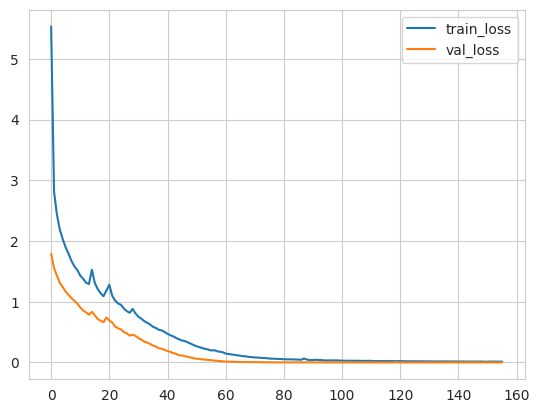

In [23]:
loss_filepath = "/content/drive/MyDrive/ITMO/T5QA/data/t5_MedQA_ans_aug_loss_156.csv"
# Plot loss
trainer_module.plot_loss(filepath=loss_filepath)

### Inference

In [14]:
test_sample = test_data.iloc[3]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  как диагностировать выпотной средний отит? также называется: оме; секреторный средний отит; серозный средний отит; тихий средний отит; тихая инфекция уха; клеевое ухо
Контекст: средний отит с выпотом соме представляет собой густую или липкую жидкость за барабанной перепонкой в ​​среднем ухе. это происходит без ушной инфекции. причины евстахиева труба соединяет внутреннюю часть уха с задней частью горла. эта трубка помогает отводить жидкость, предотвращая ее скопление в ухе. жидкость вытекает из трубки и проглатывается. соме и ушные инфекции связаны двумя способами: после лечения большинства ушных инфекций жидкость выпот остается в среднем ухе в течение нескольких дней или недель. частично заблокирован, в среднем ухе скапливается жидкость. бактерии внутри уха попадают в ловушку и начинают расти. это может привести к ушной инфекции. следующие факторы могут вызвать отек слизистой оболочки евстахиевой трубы, что приводит к увеличению количества жидкости в среднем ухе: аллергия раз

In [19]:
test_sample = test_data.iloc[19]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что делать при передозировке ацетаминофеном? также называется: передозировка тайленола; передозировка парацетамола
Контекст: ацетаминофен наиболее распространенное торговое название тайленол обезболивающее. передозировка ацетаминофеном происходит, когда ктото принимает больше рекомендуемого количества этого лекарства. передозировка ацетаминофеном является одним из наиболее распространенных отравлений. люди часто думают, что это лекарство очень безопасно. однако при приеме в больших дозах он может быть смертельным. эта статья предназначена только для информации. не используйте его для лечения или контроля фактической передозировки. если у вас или у когото из вас произошла передозировка, позвоните по местному номеру службы экстренной помощи например, 911 или в местный токсикологический центр можно связаться напрямую, позвонив по национальной бесплатной горячей линии помощи при отравлениях 18002221222 по телефону где угодно в соединенных штатах. где найден ацетаминофен содержится

In [20]:
test_sample = test_data.iloc[22]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  каковы методы лечения зуда джока? также называется: грибковая инфекция пах; инфекция грибковая пах; зуд в паху; стригущий лишай пах; tinea cruris; tinea паха
Контекст: зуд спортсмена это инфекция паховой области, вызванная грибком. медицинский термин tinea cruris или стригущий лишай в паху. причины: зуд спортсмена возникает, когда определенный тип грибка растет и распространяется в области паха. зуд спортсмена возникает в основном у взрослых мужчин и мальчиковподростков. у некоторых людей, страдающих этой инфекцией, также имеется микоз стопы или другой вид стригущего лишая. грибок, вызывающий зуд спортсмена, процветает в теплых и влажных местах. зуд спортсмена может быть вызван трением одежды и длительной влажностью в области паха, например, изза потоотделения. грибковая инфекция стоп может распространиться на паховую область при натягивании брюк, если пояс загрязнен грибком с ног. спортивный зуд может передаваться от одного человека к другому при прямом контакте кожа к коже и

In [21]:
test_sample = test_data.iloc[14]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  нужно ли мне обращаться к врачу по поводу проблем с глотанием?
Контекст: затруднение глотания это ощущение, что пища или жидкость застревает в горле или в любой момент перед попаданием пищи в желудок. эту проблему также называют дисфагией. она может быть вызвана расстройством головного мозга или нервов, стрессом или тревогой, а также проблемами, затрагивающими заднюю часть языка, горло и пищевод трубку, ведущую от горла к желудку. ожидаемые дома симптомы проблем с глотанием включают в себя: кашель или удушье во время или после еды булькающие звуки в горле во время или после еды прочищение горла после питья или глотания медленное пережевывание или прием пищи повторный кашель после еды икота после глотания дискомфорт в груди во время или после глотания необъяснимая потеря веса симптомы могут быть легкими или тяжелыми. уход на дому большинству людей с дисфагией следует обратиться к врачу, если симптомы сохраняются или возвращаются. но эти общие советы могут помочь. во время еды с